In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os
import tqdm
import json
import zipfile
import tarfile
import pickle
import numpy as np
import urllib.request

In [ ]:
filepath = '/content/gdrive/My Drive/train-v2.0.json'
with open(filepath) as f:
    data = json.load(f)

In [ ]:
from spacy.lang.en import English
tokenizer = English()

def word_tokenize(sent):
    return [token.text for token in tokenizer(sent)]

def clean_text(text):
    text = text.replace("]", " ] ")
    text = text.replace("[", " [ ")
    text = text.replace("\n", " ")
    text = text.replace("''", '" ').replace("``", '" ')

    return text

def convert_idx(text, tokens):
    current = 0
    spans = []
    for token in tokens:
        current = text.find(token, current)
        if current < 0:
            print("Token {} cannot be found".format(token))
            raise Exception()
        spans.append((current, current + len(token)))
        current += len(token)
    return spans

# these lists contain arrays, where each array contains tokens
# context_file[i] will correspond to question_file[i] etc, and a token is a word
context_file = []
question_file = []
answer_file = []
labels_file = []

quesCount = {"Who":0,"What":0,"When":0,"Where":0}
lenCount = dict()

for article_id in tqdm.tqdm(range(len(data['data']))):
    list_paragraphs = data['data'][article_id]['paragraphs']
    # loop over the paragraphs
    for paragraph in list_paragraphs:
        context = paragraph['context']
        context = clean_text(context)
        context_tokens = [w for w in word_tokenize(context) if w]
        spans = convert_idx(context, context_tokens)
        qas = paragraph['qas']
        # loop over Q/A
        for qa in qas:
            question = qa['question']
            question = clean_text(question)
            question_tokens = [w for w in word_tokenize(question) if w]
            # if str(question_tokens[0]) in quesCount:
            #     quesCount[str(question_tokens[0])]+=1
            # elif len(question_tokens)>1 and str(question_tokens[1]) in quesCount:
            #     quesCount[str(question_tokens[1])]+=1
            factoid = False

            for qtype in quesCount:
                if qtype in question_tokens:
                    factoid = True
                    quesCount[qtype]+=1
                    break
                elif (qtype.lower()) in question_tokens:
                    factoid = True
                    quesCount[qtype]+=1
                    break

            if not factoid:
                continue

            if len(question_tokens) in lenCount:
                lenCount[len(question_tokens)]+=1
            else:
                lenCount[len(question_tokens)]=1
            # select only one ground truth, the top answer, if any answer
            answer_ids = 1 if qa['answers'] else 0
            labels = []
            if answer_ids:
                # for answer_id in range(answer_ids):
                answer_id = 0
                answer = qa['answers'][answer_id]['text']
                answer = clean_text(answer)
                answer_tokens = [w for w in word_tokenize(answer) if w]
                if len(answer_tokens)>9:
                    continue
                answer_start = qa['answers'][answer_id]['answer_start']
                answer_stop = answer_start + len(answer)
                answer_span = []
                for idx, span in enumerate(spans):
                    if not (answer_stop <= span[0] or answer_start >= span[1]):
                        answer_span.append(idx)
                if not answer_span:
                    continue
                labels.append([answer_span[0], answer_span[-1]])
                # labels.append(str(answer_span[0]) + ' ' + str(answer_span[-1]))

                context_file.append([token for token in context_tokens])
                question_file.append([token for token in question_tokens])
                answer_file.append([token for token in answer_tokens])
                labels_file.append(labels)

100%|██████████| 442/442 [00:56<00:00,  7.77it/s]


In [ ]:
len(question_file)

64293

In [ ]:
import matplotlib.pyplot as plt

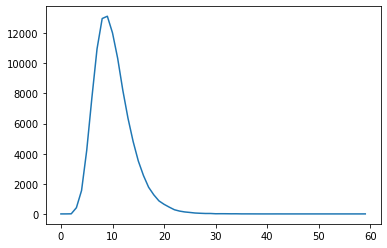

In [ ]:
maxlen = max(lenCount.keys())
hist = [0 for i in range(maxlen)]
for i in range(1,maxlen+1):
    if i not in lenCount:
        continue
    hist[i-1]+=lenCount[i]

plt.plot(hist)
plt.show()

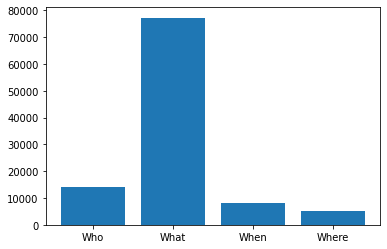

In [ ]:

names = list(quesCount.keys())
values = list(quesCount.values())

plt.bar(range(len(quesCount)), values, tick_label=names)
plt.show()

In [ ]:
sum(values)

104654

In [ ]:
sum(hist)

104654

In [ ]:
print(len(question_file),len(answer_file),len(labels_file))

64293 64293 64293


In [ ]:
question_file[:5]

In [ ]:
answer_file[:5]

In [ ]:
labels_file[:5]

In [ ]:
# VOCAB MAKER

word2idx = dict()
idx2word = dict()
idx=0
for tokenset in context_file:
    for token in tokenset:
        if token not in word2idx:
            word2idx[token]=idx
            idx2word[idx]=token
            idx+=1
for tokenset in question_file:
    for token in tokenset:
        if token not in word2idx:
            word2idx[token]=idx
            idx2word[idx]=token
            idx+=1


In [ ]:
with open("/content/gdrive/My Drive/word2idx.json", "w") as outfile:
    json.dump(word2idx, outfile)

with open("/content/gdrive/My Drive/idx2word.json", "w") as outfile:
    json.dump(idx2word, outfile)

In [ ]:
print(len(word2idx),len(idx2word),idx)

100195 100195 100195


In [ ]:
for i in range(500,519):
    print(i,idx2word[i])

500 Album
501 or
502 Rap
503 New
504 multi
505 platinum
506 Writing
507 Wall
508 1999
509 features
510 some
511 widely
512 known
513 such
514 Bills
515 single
516 Jumpin
517 '
518 Say


In [ ]:
!python3 -m spacy download en_core_web_md

## AFTER RUNNING THIS, GO TO RUNTIME AND RESTART RUNTIME TO BE ABLE TO USE EN_CORE_WEB_MD

     |████████████████████████████████| 96.4 MB 1.3 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051301 sha256=1f45773609453a4227f9fa8588ee88657e4ed45d94becb3b79907ff082ff1970
  Stored in directory: /tmp/pip-ephem-wheel-cache-5i313a99/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
import spacy
nlp = spacy.load('en_core_web_md')

def word2vec(word):
    return list(nlp(word).vector)

OSError: ignored

In [ ]:
list(word2vec('in'))

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset): # inherited Dataset
    def __init__(self,context_file,question_file,answer_file,labels_file):
        self.contexts = self.embed(context_file)
        self.questions = self.embed(question_file)
        self.answers = self.embed(answer_file)
        self.labels = (labels_file)

    def __len__(self):
        return len(self.questions)

    def __getitem__(self,idx):
        return torch.FloatTensor(self.contexts[idx]), torch.FloatTensor(self.questions[idx]), torch.FloatTensor(self.labels[idx]) ## CAN CHANGE IF WANTED

    def embed(self,file):
        embedded = []
        for tokenset in file:
            vectorset = []
            for token in tokenset:
                vectorset.append(word2vec(token))
            embedded.append(vectorset)
        return embedded

In [ ]:
# CREATING AND TESTING DATALOADER ON A SMALL PART OF THE DATA
from torch.nn.utils.rnn import *

def pad_collate(batch):
  (xx1, xx2, yy) = zip(*batch)
  x1_lens = [len(x) for x in xx1]
  x2_lens = [len(x) for x in xx2]
  y_lens = [len(y) for y in yy]

  xx1_pad = pad_sequence(xx1, batch_first=True, padding_value=0)
  xx2_pad = pad_sequence(xx2, batch_first=True, padding_value=0)
  yy_pad = pad_sequence(yy, batch_first=True, padding_value=0)

  return xx1_pad, xx2_pad, yy_pad, x1_lens, x2_lens, y_lens

dataset = CustomDataset(context_file[:5],question_file[:5],answer_file[:5],labels_file[:5])
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=pad_collate)

In [ ]:
[[y.shape for y in x] for x in dataset]

In [ ]:
for instance in data_loader:
    print(instance)